In [656]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [657]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
rpy.set_seed(402) 

In [658]:
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import MinMaxScaler 

In [659]:
def plotfig(a, b, c, time, sinal, Label, cor, xlabel, ylabel, title):
    plt.figure(figsize=(12,6))
    plt.subplot(a, b, c)  # (n_linhas, n_colunas, índice)
    plt.plot(time, sinal, label=Label, color=cor)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# SINAL APRBS DO BCS

In [660]:
# Parâmetros do sinal 
t_final, dt = 10000, 2             # final e passo
t = np.arange(0, t_final, dt)
min_step, max_step = 600/60, 6000/60 # tempo entre trocas 


FRENQUÊNCIA:

In [661]:
# Sinal de Frequência APRBS
min_value_f, max_value_f = 35, 60   # limites
f = np.zeros_like(t)

current_value = np.random.uniform(min_value_f, max_value_f)
time_next_change = 0

for i in range(len(t)):
    if t[i] >= time_next_change:
        current_value = np.random.uniform(min_value_f, max_value_f)
        time_next_change = t[i] + np.random.uniform(min_step, max_step)
        #print(time_next_change-t[i])
    f[i] = current_value


ABERTURA DE VÁLVULA:

In [662]:
# Sinal de Abertura APRBS
min_value_zc, max_value_zc = 5, 100   # limites
Zc = np.zeros_like(t)

current_value = np.random.uniform(min_value_zc, max_value_zc)
time_next_change = 0

for i in range(len(t)):
    if t[i] >= time_next_change:
        current_value = np.random.uniform(min_value_zc, max_value_zc)
        time_next_change = t[i] + np.random.uniform(min_step, max_step)
        #print(time_next_change-t[i])
    Zc[i] = current_value

PLOT GRÁFICO:

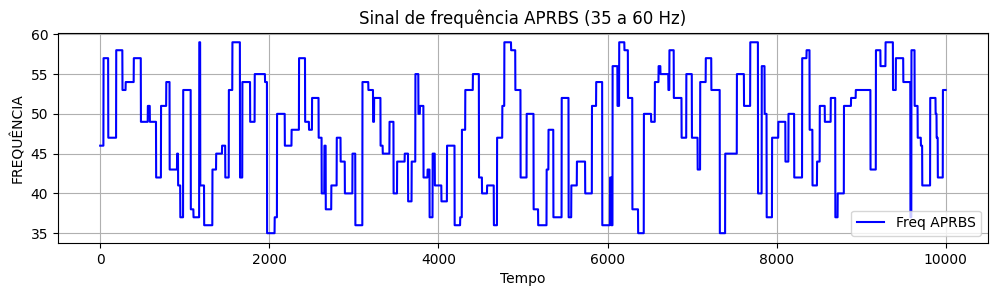

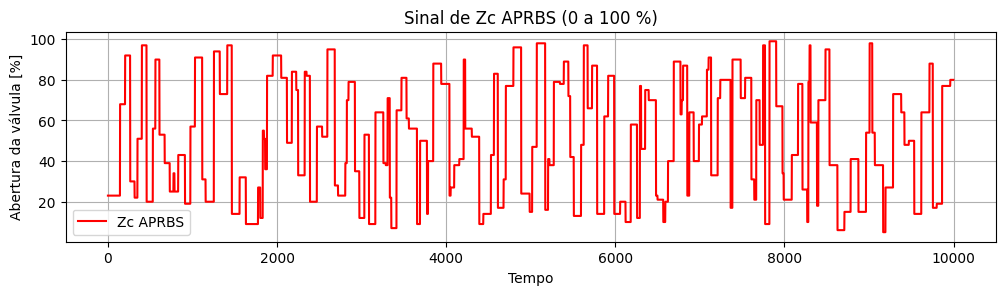

In [663]:
plotfig(2,1,1,t,f,"Freq APRBS",'b',"Tempo","FREQUÊNCIA","Sinal de frequência APRBS (35 a 60 Hz)")
plotfig(2,1,2,t,Zc,"Zc APRBS",'r',"Tempo","Abertura da válvula [%]","Sinal de Zc APRBS (0 a 100 %)")

ARQUIVO CSV:

In [664]:
Entradas = pd.DataFrame({
    "f(Hz)": f,
    "Zc(%)": Zc
}) 
Entradas.to_csv("Entradas_3_BCS.csv", index=False)

# IMPORTE RESPOSTAS

In [665]:
Saidas = pd.read_excel("Saidas_3_xlsx.xlsx")
Saidas = Saidas.to_numpy()
#Saidas = np.repeat(Saidas, 2, axis=0)
Entradas = Entradas.to_numpy()
P_in = Saidas[:,0].reshape(-1,1)
H = Saidas[:,1].reshape(-1,1)
print(P_in.shape)
print(H.shape)

(5000, 1)
(5000, 1)


# GERANDO MODELO

NORMALIZAÇÃO:

In [666]:
scaler_in = MinMaxScaler(feature_range=(-1, 1))
Entradas_norm = scaler_in.fit_transform(Entradas)   # entradas normalizadas

scaler_out = MinMaxScaler(feature_range=(-1, 1))
Saidas_norm = scaler_out.fit_transform(Saidas)   # saídas normalizadas

DIVISÃO DE DADOS:

In [667]:
x_aux, y_aux = Entradas_norm[2500:], Saidas_norm[2500:]
# Treino 
X_train, Y_train = Entradas_norm[:2500], Saidas_norm[:2500]
# Teste
X_test, Y_test = x_aux[:1250], y_aux[:1250]
# Validação
X_valid, Y_valid = x_aux[1250:], y_aux[1250:]

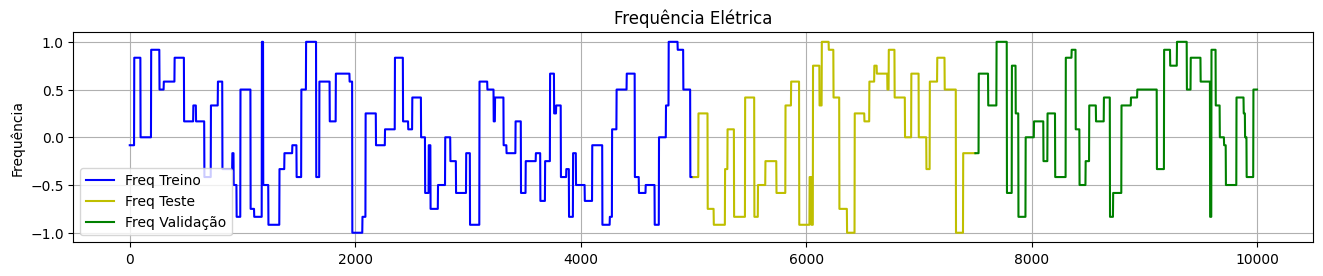

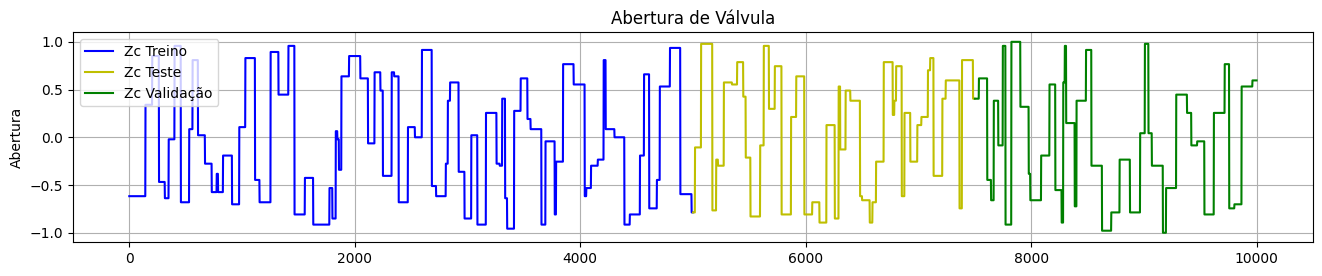

In [668]:
t_a = np.arange(0, t_final/2, 2)
t_b = np.arange(t_final/2, 3*t_final/4, 2)
t_c = np.arange(3*t_final/4, t_final, 2)

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, X_train[:,0], label="Freq Treino", color='b')
plt.plot(t_b, X_test[:,0], label="Freq Teste", color='y')
plt.plot(t_c, X_valid[:,0], label="Freq Validação", color='g')
plt.ylabel("Frequência")
plt.title("Frequência Elétrica")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 2)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, X_train[:,1], label="Zc Treino", color='b')
plt.plot(t_b, X_test[:,1], label="Zc Teste", color='y')
plt.plot(t_c, X_valid[:,1], label="Zc Validação", color='g')
plt.ylabel("Abertura")
plt.title("Abertura de Válvula")
plt.grid(True)
plt.legend()
plt.show()

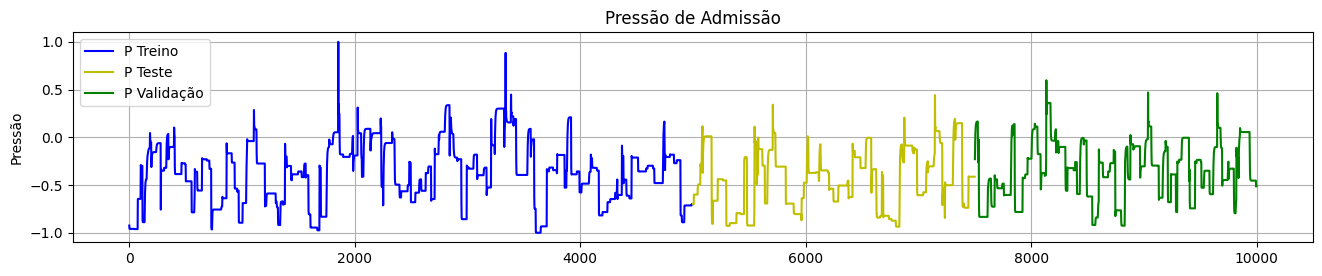

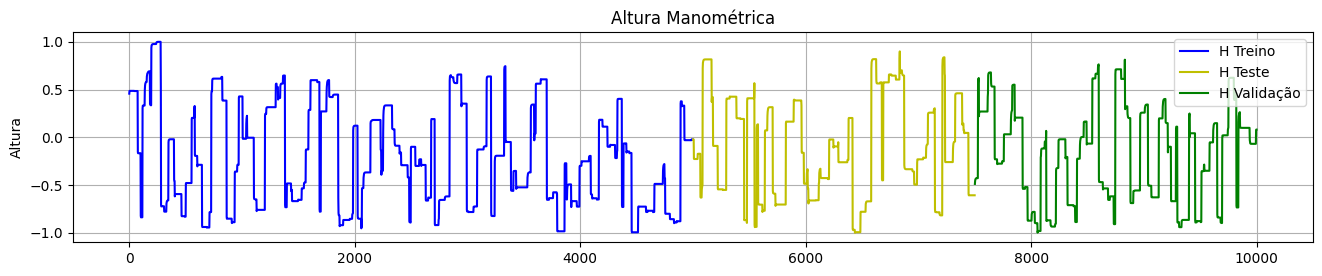

In [669]:
plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, Y_train[:,0], label="P Treino", color='b')
plt.plot(t_b, Y_test[:,0], label="P Teste", color='y')
plt.plot(t_c, Y_valid[:,0], label="P Validação", color='g')
plt.ylabel("Pressão")
plt.title("Pressão de Admissão")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 2)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, Y_train[:,1], label="H Treino", color='b')
plt.plot(t_b, Y_test[:,1], label="H Teste", color='y')
plt.plot(t_c, Y_valid[:,1], label="H Validação", color='g')
plt.ylabel("Altura")
plt.title("Altura Manométrica")
plt.grid(True)
plt.legend()
plt.show()


Estrutura:

In [670]:
reservoir = Reservoir(units=1500, lr=0.1, sr=0.1)
readout = Ridge(ridge=1e-4)

BCS_model = reservoir >> readout

TREINAMENTO:

In [671]:
BCS_model = BCS_model.fit(X_train, Y_train, warmup=0)
print(reservoir.initialized, readout.initialized)

True True


TESTE:

(1250, 2)


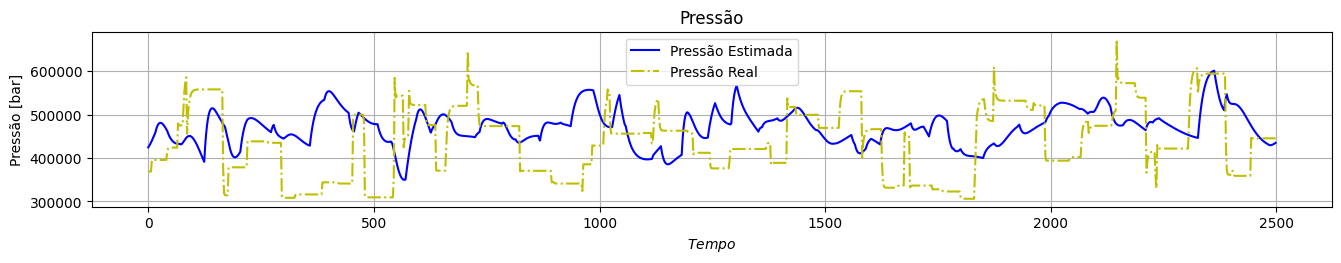

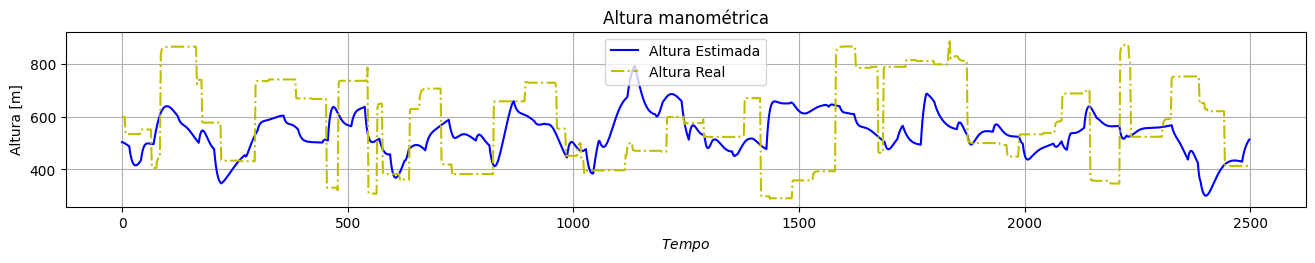

R² (P): -0.4733297563072494
R² (H): -0.18732949349984107


In [672]:
Y_pred = BCS_model.run(X_test)
print(Y_pred.shape)

Y_pred = scaler_out.inverse_transform(Y_pred)
Y_test = scaler_out.inverse_transform(Y_test)

t_ = np.arange(0, t_final/4, 2)


plt.figure(figsize=(16,5))
plt.subplot(2, 1, 1) 
plt.title("Pressão")
plt.xlabel("$Tempo$")
plt.ylabel("Pressão [bar]")
plt.plot(t_, Y_pred[:,0]/(10^(5)), label="Pressão Estimada", color="blue", linestyle="-")
plt.plot(t_, Y_test[:,0]/(10^(5)), label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(2, 1, 2) 
plt.title("Altura manométrica")
plt.xlabel("$Tempo$")
plt.ylabel("Altura [m]")
plt.plot(t_, Y_pred[:,1], label="Altura Estimada", color="blue", linestyle="-")
plt.plot(t_, Y_test[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

R2_p = r2_score(Y_test[:,0], Y_pred[:,0])
R2_h = r2_score(Y_test[:,1], Y_pred[:,1])
print(f"R² (P): {R2_p}")
print(f"R² (H): {R2_h}")

VALIDAÇÃO:

(1250, 2)


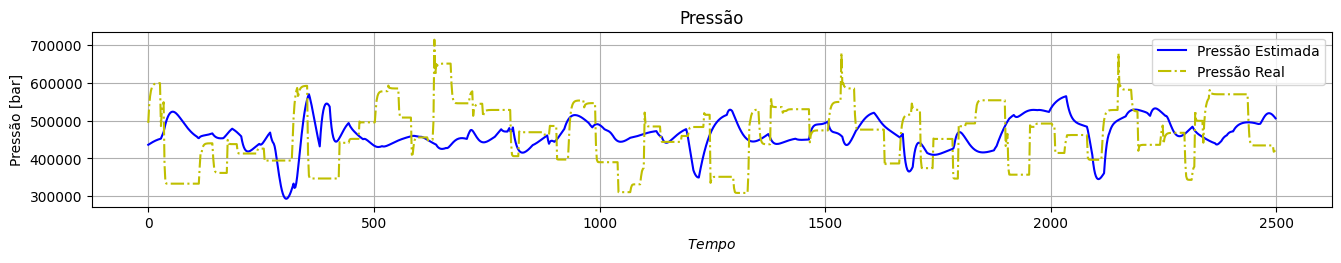

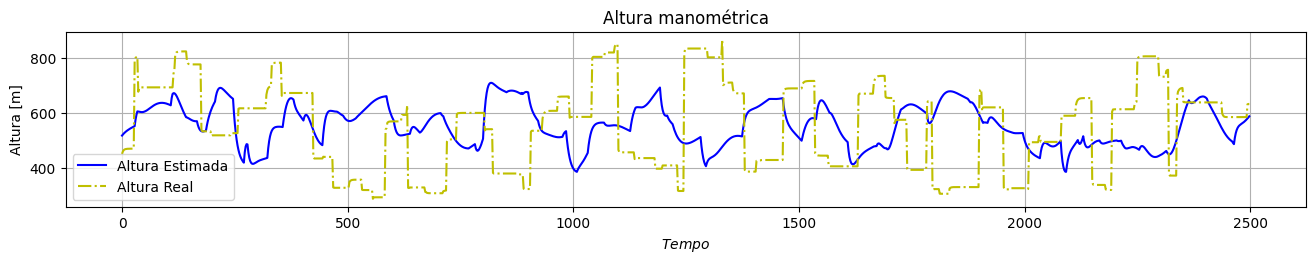

R² (P): -0.44180911084381935
R² (H): -0.5523431405372556


In [673]:
Y_pred = BCS_model.run(X_valid)
print(Y_pred.shape)

Y_pred = scaler_out.inverse_transform(Y_pred)
Y_valid = scaler_out.inverse_transform(Y_valid)

plt.figure(figsize=(16,5))
plt.subplot(2, 1, 1) 
plt.title("Pressão")
plt.xlabel("$Tempo$")
plt.ylabel("Pressão [bar]")
plt.plot(t_, Y_pred[:,0]/(10^(5)), label="Pressão Estimada", color="blue", linestyle="-")
plt.plot(t_, Y_valid[:,0]/(10^(5)), label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(2, 1, 2) 
plt.title("Altura manométrica")
plt.xlabel("$Tempo$")
plt.ylabel("Altura [m]")
plt.plot(t_, Y_pred[:,1], label="Altura Estimada", color="blue", linestyle="-")
plt.plot(t_, Y_valid[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

R2_p = r2_score(Y_valid[:,0], Y_pred[:,0])
R2_h = r2_score(Y_valid[:,1], Y_pred[:,1])
print(f"R² (P): {R2_p}")
print(f"R² (H): {R2_h}")

(5000, 2)


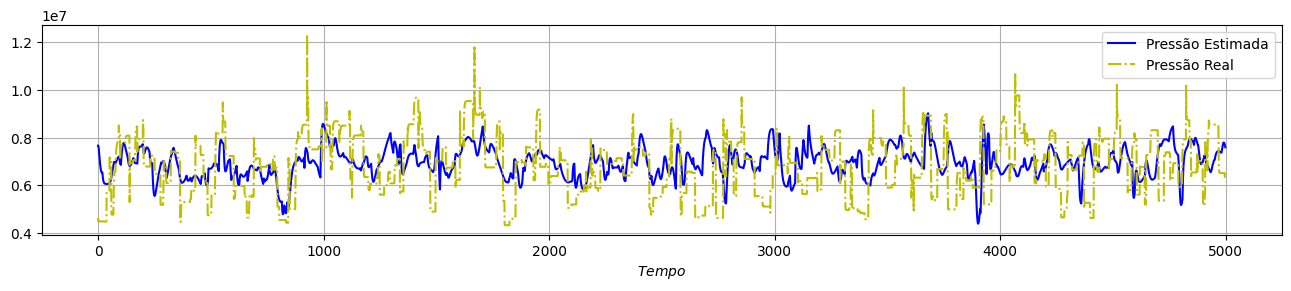

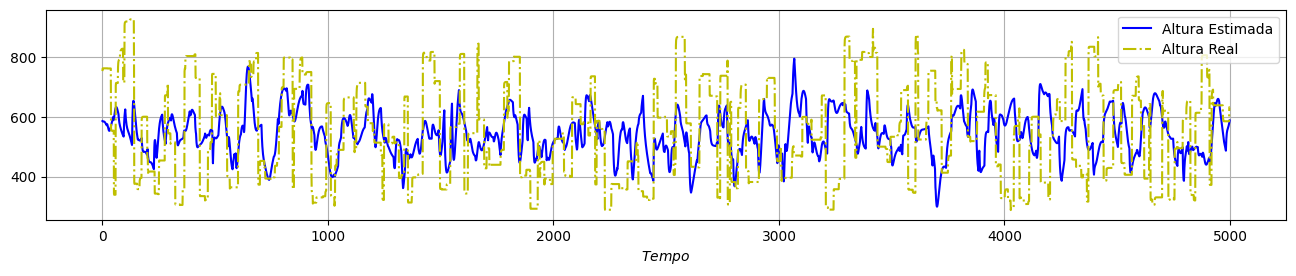

R² (P): -0.04511064285531785
R² (H): -0.056455697641783376


In [674]:
Y_pred = BCS_model.run(Entradas_norm)
print(Y_pred.shape)

Y_pred = scaler_out.inverse_transform(Y_pred)
Saidas_norm = scaler_out.inverse_transform(Saidas_norm)

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1) 
plt.title("")
plt.xlabel("$Tempo$")
plt.plot(Y_pred[:,0], label="Pressão Estimada", color="blue", linestyle="-")
plt.plot(Saidas_norm[:,0], label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 2) 
plt.title("")
plt.xlabel("$Tempo$")
plt.plot(Y_pred[:,1], label="Altura Estimada", color="blue", linestyle="-")
plt.plot(Saidas_norm[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

R2_p = r2_score(Saidas_norm[:,0], Y_pred[:,0])
R2_h = r2_score(Saidas_norm[:,1], Y_pred[:,1])
print(f"R² (P): {R2_p}")
print(f"R² (H): {R2_h}")